# Проверка гипотез по увеличению выручки в интернет-магазине

## Описание проекта

Представим, что мы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Нам надо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

Нам даны три файла в формате csv: hypothesis.csv, orders.csv и visitors.csv.

Наименования столбцов в датасете hypothesis.csv: 
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Наименования столбцов в датасете orders.csv:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Наименования столбцов в датасете visitors.csv:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Чтение файлов и изучение общей информации о данных

Для анализа у нас есть три датасета: 'hypothesis.csv', 'orders.csv' и 'visitors.csv'. Изучим данные.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv', sep=',', decimal='.')
    orders = pd.read_csv('orders.csv', sep=',', decimal='.')
    visitors = pd.read_csv('visitors.csv', sep=',', decimal='.')
except: 
    hypothesis = pd.read_csv('http://localhost:8890/edit/Downloads/hypothesis.csv', sep=',', decimal='.')
    orders = pd.read_csv('http://localhost:8890/edit/Downloads/orders.csv', sep=',', decimal='.')
    visitors = pd.read_csv('http://localhost:8890/edit/Downloads/visitors.csv', sep=',', decimal='.')

In [3]:
# уберем ограничения на количество символов в записи
pd.set_option('display.max_colwidth', None)
# выведем на экран датафрейм hypothesis
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# выведем на экран первые 10 строчек датафрейма orders
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [5]:
# выведем на экран первые 10 строчек датафрейма visitors
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Посмотрим информацию о датафреймах 'hypothesis', 'orders' и 'visitors'.

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Вывод**

Мы загрузили данные о гипотезах, заказах и данные А/В-теста из CSV-файлов в переменные hypothesis, orders и visitors. Пропусков нет, необходимо преобразовать тип данных в столбцах 'date' в датафреймах 'orders' и 'visitors' во временной тип данных, привести все названия в датафреймах к нижнему регистру и проверить на наличие явных дубликатов.

## Предобработка данных

Приведем все названия к нижнему регистру написания.

In [9]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [10]:
# добавим "змеиный регистр" в названиях столбцов
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
# выведем первые пять строк
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Преобразуем тип данных в столбцах 'date' в датафреймах 'orders' и 'visitors' во временной тип данных.

In [11]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим датафреймы на наличие явных дубликатов.

In [12]:
hypothesis.duplicated().sum()

0

In [13]:
orders.duplicated().sum()

0

In [14]:
visitors.duplicated().sum()

0

**Вывод**

В предобработке данных мы привели все названия к единому регистру написания, изменили тип данных в столбцах 'date' в датафреймах 'orders' и 'visitors' во временной тип данных. Также проверили, что в датафреймах отсутствуют явные дубликаты.

## Приоритизация гипотез.

У нас 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета. Для этого в датафрейм добавим столбец 'ice'.

In [15]:
hypothesis['ice'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).round(decimals=2)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE: 8, 0 и 7.

Теперь применим фреймворк RICE для приоритизации гипотез и также их отсортируем по убыванию приоритета. Добавим в датафрейм 'hypothesis' столбец 'rice'.

In [16]:
hypothesis['rice'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: 7, 2, 0 и 6.

Посмотрим, как изменилась приоритизация гипотез при применении RICE вместо ICE. Для этого выведем датафрейм  'hypothesis' со столбцами 'ice' и 'rice' и выделим в этих столбцах значения.

In [17]:
hypothesis_ice_rice = hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by='rice', ascending=False)
# заменим вещественный тип данных в столбцах 'ice' и 'rice' на целочисленный
hypothesis_ice_rice[['ice', 'rice']] = hypothesis_ice_rice[['ice', 'rice']].astype(int)
# задаем палитру цветов
cm = sns.light_palette("blue", as_cmap=True)
# применяем градиент фона к столбцам
hypothesis_ice_rice.style.background_gradient(cmap=cm)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",16,16
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3


**Вывод**

Наиболее перспективные гипотезы по ICE: 8, 0 и 7 (16, 13 и 11 ICE соответвенно). А наиболее перспективные гипотезы по RICE - это 7, 2, 0 и 6 (112, 56, 40 и 40 RICE соответсвенно).

Самыми приоритетными гипотезами будут гипотезы 7 ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") и 0 ("Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"), так как они перспективны и по ICE, и по RICE. Гипотеза №7 самая приоритетная, так как она охватит максимальное количество пользователей интернет-магазина и большая их часть подпишется на email-рассылку, при этом затраты на реализацию этой гипотезы будут средние. Вторая по приоритету гипотеза №0: хоть по количеству будет меньше пользователей, но это будут новые пользователи, привлеченные из двух новых источников трафика, но затраты на реализацию этой гипотезы будут немного выше, чем на реализацию 7ой гипотезы.

Гипотеза №2 ("Добавить блоки рекомендаций товаров на сайт интернет-магазина, чтобы повысить конверсию и средний чек заказа") при расчете RICE стала второй по приорететам, хотя при расчете ICE была пятой. Это случилось из-за того, что блоки рекомендаций товаров на сайт интернет-магазина увидит большее количество пользователей. При расчете ICE этот показатель не был учтен.

Гипотеза №8 ("Запустить акцию, дающую скидку на товар в день рождения") при расчете RICE стала пятой по приорететам, хотя при расчете ICE была первой. Так произошло из-за того, что день рождения у разных пользователей бывает в разные дни. Поэтому данная гипотеза охватывает очень малое количество пользователей в определенные дни, хотя подобная акция очень сильно повлияет на поведение пользователей.

Гипотеза №6 ("Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию") при расчете RICE тоже на четвертом месте по приорететам, как и при расчете ICE.

## Часть 3. Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulative_data со столбцами: 
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [18]:
# проверим: сколько у нас групп в АВ-тесте
group_orders = orders['group'].unique()
print('В датасете "orders" А/В тесте группы:', group_orders)
group_visitors = visitors['group'].unique()
print('В датасете "visitors" А/В тесте группы:', group_visitors) 

# проверим: даты начала и окончания теста
min_date_orders = orders['date'].min()
max_date_orders = orders['date'].max()
print('В датасете "orders" даты начала и окончания теста:', min_date_orders, max_date_orders)
min_date_visitors = visitors['date'].min()
max_date_visitors = visitors['date'].max()
print('В датасете "visitors" даты начала и окончания теста:', min_date_visitors, max_date_visitors)

# проверим: сколько пользователей в каждой группе
orders_A = orders.query('group == "A"')
users_A = orders_A['visitor_id'].unique()
orders_B = orders.query('group == "B"')
users_B = orders_B['visitor_id'].unique()
print('В датасете "orders" количество пользователей группы А:', len(users_A))
print('В датасете "orders" количество пользователей группы В:', len(users_B))

# проверим: попали ли какие-то пользователи в обе группы
duplicated_users = orders.groupby('visitor_id').agg({'group': 'nunique'})
duplicated_users.columns = ['groups']
duplicated_users = duplicated_users.query('groups > 1')
print('Количество пользователей, которые попали в обе группы, равно', len(duplicated_users))

В датасете "orders" А/В тесте группы: ['B' 'A']
В датасете "visitors" А/В тесте группы: ['A' 'B']
В датасете "orders" даты начала и окончания теста: 2019-08-01 00:00:00 2019-08-31 00:00:00
В датасете "visitors" даты начала и окончания теста: 2019-08-01 00:00:00 2019-08-31 00:00:00
В датасете "orders" количество пользователей группы А: 503
В датасете "orders" количество пользователей группы В: 586
Количество пользователей, которые попали в обе группы, равно 58


**Вывод**
    
Количество групп в датасетах совпадает: есть группа А и есть группа В. Также совпадают даты начала и окончания проведения теста А/В. А вот с количеством пользователей в группах возникают вопросы. Так как в группе А количество пользователей составляет 503 пользователя, а к группе В - 586 пользователей, то разделение пользователей по группам не симметрично. Также 58 пользователей попали в обе группы. Если мы удалим эти 58 пользователей из группы В (тогда в группе В будет 528 пользователей), то распределение пользователей по группам так и останется не симметричным, что скажется на дальнейшем анализе данных. Этот момент должен был быть решен еще на стадии проведения А/А теста.

In [19]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'transaction_id': 'nunique', 'visitor_id': 'nunique', 'revenue': 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим график кумулятивной выручки по группам.

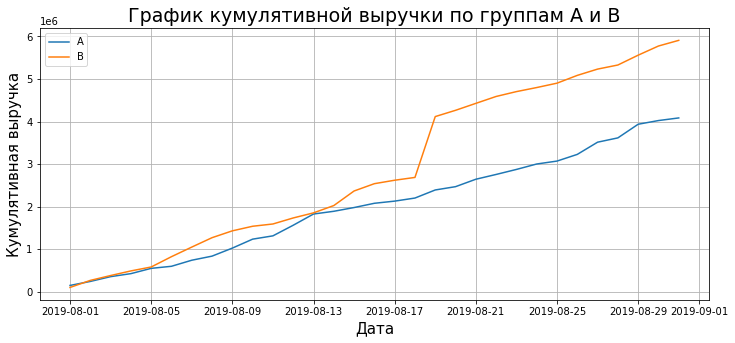

In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 5))
# строим график выручки группы А
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label='A')
# строим график выручки группы B
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label='B')

plt.grid()
plt.title('График кумулятивной выручки по группам А и В', fontsize = 19)
plt.xlabel('Дата', fontsize = 15)
plt.ylabel('Кумулятивная выручка', fontsize = 15)
plt.legend()
plt.show()

**Вывод**

Выручка в обеих группах возрастает на протяжении всего теста. Согласно графику до 5ого августа включительно выручка в группах примерно одинаково возрастает, а после выручка в группе В немного больше, чем в группе А. 13 августа 2019 года выручка в обеих группах снова практически одинаковая. Дальше по графику видно, что выручка в группе В увеличивается, а после 18 августа происходит резкий скачок выручки в этой группе, в то время, как выручка в группе А растет без резких всплесков. Возможно в период с 18 по 19 августа пользователи группы В совершили крупные заказы в интернет-магазине либо количество заказов в этой группе увеличилось, что и дало такой резкий рост выручки.

Построим график среднего чека по группам. Для этого разделим кумулятивную выручку на кумулятивное число заказов.

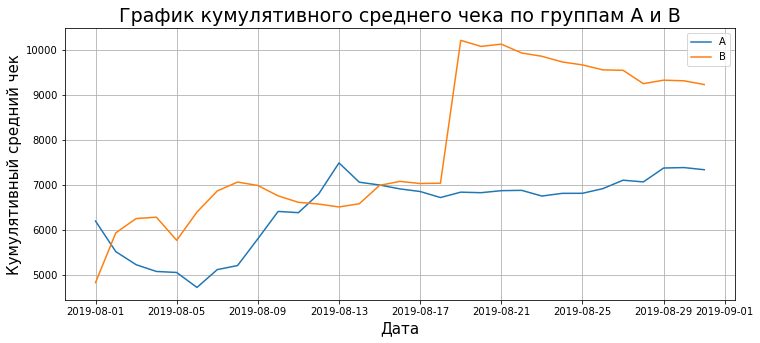

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label='B')
plt.grid()
plt.title('График кумулятивного среднего чека по группам А и В', fontsize = 19)
plt.xlabel('Дата', fontsize = 15)
plt.ylabel('Кумулятивный средний чек', fontsize = 15)
plt.legend()
plt.show()

**Вывод**

В начале теста средний чек в группе А упал, а в период с 6 по 13 августа наблюдается рост среднего чека в этой группе. Далее в период с 16 по 25 авгучта средний чек в группе А стабилизировался, а к концу теста виден небольшой рост среднего чека в этой группе. В группе В в начале теста виден резкий рост среднего чека и небольшой спад 5ого августа, после чего средний чек в этой группе снова стал возрастать. В период с 15 по 18 августа средний чек в группе В стабилизировался, а после резко увеличился. После 19 августа наблюдается падение среднего чека в группе В до конца теста. Вероятно такие всплески роста среднего чека в группе В обусловлены крупными заказами в эти периоды.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

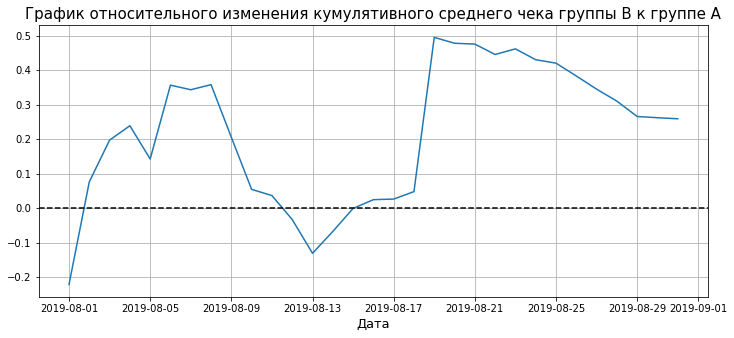

In [22]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenueA.merge(
    cumulative_revenueB, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

# cтроим отношение средних чеков
plt.figure(figsize=(12, 5))
plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenue_B']/merged_cumulative_revenue['orders_B'])/
         (merged_cumulative_revenue['revenue_A']/merged_cumulative_revenue['orders_A'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.show()

**Вывод**

В нескольких точках график различия между сегментами резко «скачет». Скорее всего на эти повлияли крупные заказы или выбросы.

Построим график кумулятивного среднего количества заказов на посетителя по группам.

**Вывод**

С начала теста конверсия группы А была больше конверсии группы В, но после 3его августа она начала снижаться. Конверсия группы В в начале сильно колебалась, а после 6ого августа стала больше конверсии группы А и была стабильно выше на протяжении проведения всего теста.

Теперь посмотрим распределение кумулятивного среднего количества заказов на посетителя по группам.

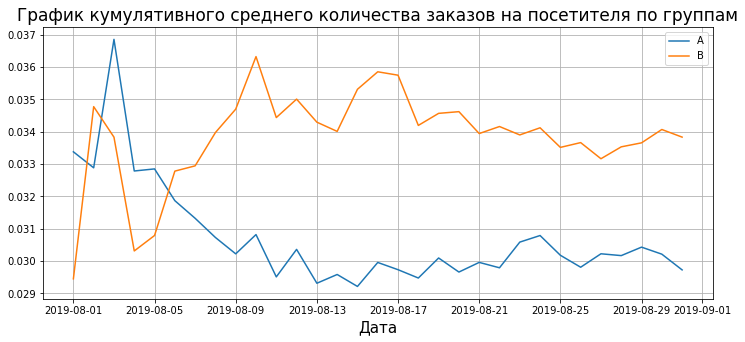

In [23]:
# считаем среднее количество заказов на посетителя
cumulative_data['mean_orders'] = cumulative_data['orders']/cumulative_data['visitors']
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(12, 5))
plt.plot(cumulative_data_A['date'], cumulative_data_A['mean_orders'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['mean_orders'], label='B')
plt.legend()
plt.grid()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize = 17)
plt.xlabel('Дата', fontsize = 15)
plt.show()

**Вывод**

С начала теста среднее количество заказов на посетителя группы А было больше среднего количества заказов на посетителя группы В, но после 3его августа оно начало снижаться. Средне количество заказов на посетителя группы В в начале сильно колебалось, а после 6ого августа стало больше среднего количества заказов на посетителя группы А и было стабильно выше на протяжении проведения всего теста.

Теперь построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A, то есть построим график относительного различия кумулятивных конверсий.

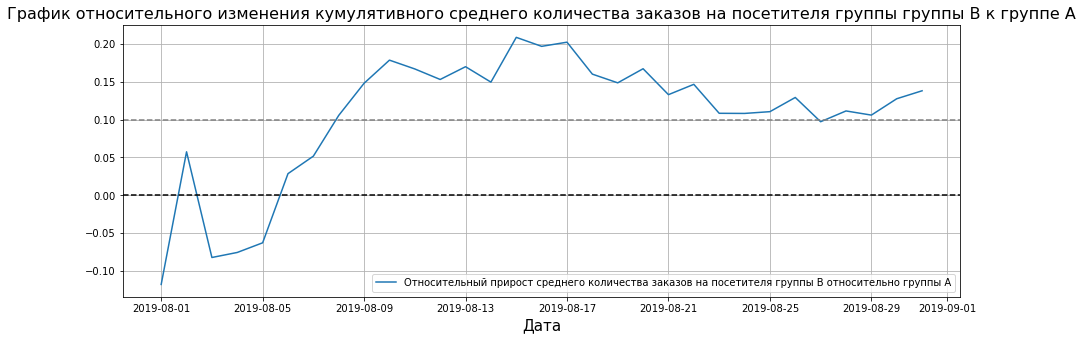

In [24]:
merged_cumulative_mean_orders = cumulative_data_A[['date','mean_orders']].merge(
    cumulative_data_B[['date','mean_orders']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

plt.figure(figsize=(15, 5))
plt.plot(merged_cumulative_mean_orders['date'], merged_cumulative_mean_orders['mean_orders_B']/
         merged_cumulative_mean_orders['mean_orders_A']-1, 
         label="Относительный прирост среднего количества заказов на посетителя группы B относительно группы A")
plt.legend()
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title(
    'График относительного изменения кумулятивного среднего количества заказов на посетителя группы группы B к группе A', 
    fontsize = 16)
plt.xlabel('Дата', fontsize = 15)
plt.show()

**Вывод**

В начале теста прирост среднего количества заказов на посетителя группы В был ниже прироста группы А. После 5ого августа прирост среднего количества заказов на посетителя группы В стал расти относительно группы А и был выше в период с 8ого августа по 23е августа. Далее прирост среднего количества заказов на посетителя группы В стал почти близок к приросту среднего количества заказов группы А, а к концу теста снова стал увеличиваться.

Построим точечный график количества заказов по пользователям. Для этого сгруппируем заказы по пользователям и подсчитает число уникальных заказов по сгруппированным данным.

In [25]:
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})) 
orders_by_users.columns = ['user_id', 'orders']
# отсортируем по убыванию количества заказов пользователей и выведем на экран первые 10 строк.
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


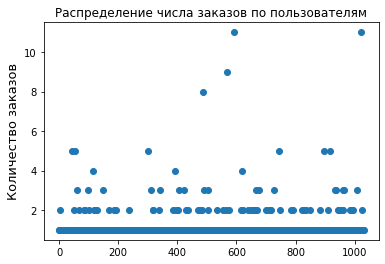

In [26]:
# строим точечную диаграмму
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])
plt.title('Распределение числа заказов по пользователям')
plt.ylabel('Количество заказов', fontsize = 13)
plt.show()

**Вывод**

Большинство пользователей сделали 1 заказ. Есть несколько пользователей, которые сделали от 2х до 3х заказов. А также согласно точечной диаграмме, два пользователя совершили по 11 заказов, один пользователей - 9 заказов, один пользователей - 8 заказов, 6 пользователей - по 5 заказов и три пользователя - по 4 заказа.

Определим 95-й и 99-й перцентили количества заказов на пользователя.

In [27]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

**Вывод**

Не более 5% пользователей оформили 2 заказа и 1% пользователей, которые оформили 4 заказа. Следует отсеять пользователей, которые совершили от 2х до 11ти заказов.

Теперь построим точечный график стоимостей заказов.

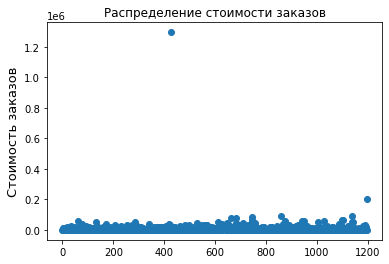

In [28]:
# строим точечную диаграмму
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказов', fontsize = 13)
plt.show()

**Вывод**

По точечной диаграмме видно, что есть заказ стоимостью более 1.2 млн. Такой заказ выглядит аномально. Вероятно он и оказывает влияние на скачки на графиках кумулятивных данных.

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [29]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% пользователей оформили заказы стоимостью 28 000 и 1% пользователей, которые оформили заказы стоимостью 58 233,2. Следует отсеять пользователей, которые совершили заказы стоимостью от 28 000.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным - без удаления аномальных пользователей.

Сформулируем гипотезы. 
* Нулевая: нет различий в среднем количестве заказов между группами А и В. 
* Альтернативная: различия в среднем количестве заказов между группами А и В есть.

Создадим переменные visitors_A_daily, visitors_B_daily, orders_A_daily, orders_В_daily для расчета статистической значимости различий в среднем количестве заказов на посетителя между группами.

In [30]:
# подготовим данные
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# создадим переменные orders_by_users_A и orders_by_users_B
orders_by_users_A = (orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)
                     .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = (orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)
                     .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['user_id', 'orders']

# объявим переменные sample_A и sample_B, в которых пользователям из разных групп будет соответствовать количество заказов
sample_A = pd.concat([orders_by_users_A['orders'],pd.Series(
    0, index=np.arange(visitors_A_daily['visitors_per_date_A'].sum()-len(orders_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'],pd.Series(
    0, index=np.arange(visitors_B_daily['visitors_per_date_B'].sum()-len(orders_by_users_B['orders'])), name='orders')],axis=0)

print("P-value равен {0:.3f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))

print("Относительный прирост среднего числа заказов группы B равен {0:.3f}"
      .format((orders_B_daily['orders_per_date_B'].sum()/visitors_B_daily['visitors_per_date_B'].sum())/
                  (orders_A_daily['orders_per_date_A'].sum()/visitors_A_daily['visitors_per_date_A'].sum())-1))

P-value равен 0.017
Относительный прирост среднего числа заказов группы B равен 0.138


**Вывод**

По «сырым» данным различия в среднем числе заказов групп A и B есть: p-value меньше 5% (p-value равен 1,7%). Значит, нулевую гипотезу о том, что различий в среднем количестве заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13,8%.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами по «сырым» данным. 
* Нулевая гипотеза: нет различий в среднем чеке между группами А и В. 
* Альтернативная гипотеза: различия в среднем чеке между группами А и В есть. 

In [31]:
print("P-value равен {0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                     orders[orders['group']=='B']['revenue'])[1]))
print("Относительный прирост среднего чека группы B равен {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/
                                                                          orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value равен 0.729
Относительный прирост среднего чека группы B равен 0.259


**Вывод**

По "сырым" данным различий в среднем чеке между группами А и В нет: р-value значительно больше 5% (р-value равен 72,9%). Значит, у нас нет причин отвергать нулевую гипотезу, что в среднем чеке есть различия. Однако средний чек группы B выше среднего чека группы A на 25,9%.

Теперь посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Для начала узнаем: сколько всего аномальных пользователей.

In [32]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > np.percentile(orders_by_users['orders'], 95)]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > np.percentile(orders_by_users['orders'], 95)]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
print("Всего {0:.0f} аномальных пользователя".format(abnormal_users.shape[0]))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64

Всего 74 аномальных пользователя


In [33]:
# создадим переменные sample_A_filtered и sample_B_filtered, в которых сохраним очищенные данные о заказах — 
# не включая аномальных пользователей
sample_A_filtered = pd.concat(
    [orders_by_users_A[np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))]['orders'], 
     pd.Series(0,index=np.arange(visitors_A_daily['visitors_per_date_A'].sum()-
                                 len(orders_by_users_A['orders'])), name='orders')], axis=0)

sample_B_filtered = pd.concat(
    [orders_by_users_B[np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))]['orders'], 
     pd.Series(0, index=np.arange(visitors_B_daily['visitors_per_date_B'].sum()-
                                  len(orders_by_users_B['orders'])), name='orders')], axis=0)

# применим статистический критерий Манна-Уитни к полученным выборкам
print("P-value равен {0:.3f}".format(st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print("Относительный прирост среднего числа заказов группы B равен {0:.3f}".format(sample_B_filtered.mean()/
                                                                                   sample_A_filtered.mean()-1))

P-value равен 0.013
Относительный прирост среднего числа заказов группы B равен 0.173


**Вывод**

По «очищенным» данным различия в среднем числе заказов групп A и B есть: p-value меньше 5% (p-value равен 1,3%). Значит, нулевую гипотезу о том, что различий в среднем количестве заказов между группами нет, отвергаем. Относительный выигрыш группы B увеличился по сравнению с "сырыми" данными и равен 17,3%.

Теперь посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [34]:
print(
    "P-value равен {0:.3f}".format(
        st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', 
                            np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'], 
                                orders[np.logical_and(orders['group'] == 'B', 
                                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1])
)

print(
    "Относительный прирост среднего чека группы B равен {0:.3f}".format(
        orders[np.logical_and(orders['group'] == 'B', 
                              np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A', 
                                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()-1)
)

P-value равен 0.738
Относительный прирост среднего чека группы B равен -0.020


**Вывод**

По "очищенным" данным различий в среднем чеке между группами А и В нет: р-value значительно больше 5% (р-value равен 73,8%). Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы B без выбросов стал меньше среднего чека группы A на 2%.

## Принятие решения по результатам теста.

Так как выручка в обеих группах на протяжении всего теста возрастает, а после 13ого августа видно, что выручка в группе В больше по сравнению с выручкой группы А.

С начала теста среднее количество заказов на посетителя группы А было больше среднего количества заказов на посетителя группы В, но после 3его августа оно начало снижаться. Средне количество заказов на посетителя группы В в начале сильно колебалось, а после 6ого августа стало больше среднего количества заказов на посетителя группы А и было стабильно выше на протяжении проведения всего теста.

Есть статистически значимое различие по среднему количеству заказов между группами А и В и по «сырым», и по данным после фильтрации аномалий. Относительный выигрыш группы B равен 13,8% при "сырых данных" и относительный выигрыш группы B "очищенными" данными равен 17,3%.

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Однако по "сырым" данным средний чек группы B выше среднего чека группы A на 25,9%, а по "очищенным" данным средний чек группы B стал меньше среднего чека группы A на 2%.

А вот график относительного изменения кумулятивного среднего чека группы B к группе A сильно «скачет», благодаря чему мы нашли выбросы. Сделать из этого графика определённые выводы нельзя.

Исходя из выше перечисленных фактов, можно сделать вывод: остановить тест и зафиксировать победу за группой В.

## Итоговый вывод

Мы загрузили данные о гипотезах, заказах и данные А/В-теста из CSV-файлов в переменные hypothesis, orders и visitors. Изучив информацию о данных, сделали предобработку данных: привели все названия к единому регистру написания, изменили тип данных в столбцах 'date'в датафреймах 'orders' и 'visitors' во временной тип данных. Также проверили, что в датафреймах отсутствуют явные дубликаты.

Мы применили метод ICE к датафрейму 'hypothesis' для приоритизации гипотез и наиболее перспективные гипотезы по ICE: 8, 0 и 7 (16, 13 и 11 ICE соответвенно). А при применении метода RICE к датафрейму с гипотезами наиболее перспективные гипотезы - это 7, 2, 0 и 6 (112, 56, 40 и 40 RICE соответсвенно).

Самыми приоритетными гипотезами будут гипотезы 7 ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") и 0 ("Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"), так как они перспективны и по ICE, и по RICE. Гипотеза №7 самая приоритетная, так как она охватит максимальное количество пользователей интернет-магазина и большая их часть подпишется на email-рассылку, при этом затраты на реализацию этой гипотезы будут средние. Вторая по приоритету гипотеза №0: хоть по количеству будет меньше пользователей, но это будут новые пользователи, привлеченные из двух новых источников трафика, но затраты на реализацию этой гипотезы будут немного выше, чем на реализацию 7ой гипотезы.

Гипотеза №2 ("Добавить блоки рекомендаций товаров на сайт интернет-магазина, чтобы повысить конверсию и средний чек заказа") при расчете RICE стала второй по приорететам, хотя при расчете ICE была пятой. Это случилось из-за того, что блоки рекомендаций товаров на сайт интернет-магазина увидит большее количество пользователей. При расчете ICE этот показатель не был учтен.

Гипотеза №8 ("Запустить акцию, дающую скидку на товар в день рождения") при расчете RICE стала пятой по приорететам, хотя при расчете ICE была первой. Так произошло из-за того, что день рождения у разных пользователей бывает в разные дни. Поэтому данная гипотеза охватывает очень малое количество пользователей в определенные дни, хотя подобная акция очень сильно повлияет на поведение пользователей.

Гипотеза №6 ("Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию") при расчете RICE тоже на четвертом месте по приорететам, как и при расчете ICE.

Выручка в обеих группах возрастает на протяжении всего теста. Согласно графику до 5ого августа включительно выручка в группах примерно одинаково возрастает, а после выручка в группе В немного больше, чем в группе А. 13 августа 2019 года выручка в обеих группах снова практически одинаковая. Дальше по графику видно, что выручка в группе В увеличивается, а после 18 августа происходит резкий скачок выручки в этой группе, в то время, как выручка в группе А растет без резких всплесков. Возможно в период с 18 по 19 августа пользователи группы В совершили крупные заказы в интернет-магазине либо количество заказов в этой группе увеличилось, что и дало такой резкий рост выручки.

В начале теста средний чек в группе А упал, а в период с 6 по 13 августа наблюдается рост среднего чека в этой группе. Далее в период с 16 по 25 авгучта средний чек в группе А стабилизировался, а к концу теста виден небольшой рост среднего чека в этой группе. В группе В в начале теста виден резкий рост среднего чека и небольшой спад 5ого августа, после чего средний чек в этой группе снова стал возрастать. В период с 15 по 18 августа средний чек в группе В стабилизировался, а после резко увеличился. После 19 августа наблюдается падение среднего чека в группе В до конца теста. Вероятно такие всплески роста среднего чека в группе В обусловлены крупными заказами в эти периоды.

С начала теста среднее количество заказов на посетителя группы А было больше среднего количества заказов на посетителя группы В, но после 3его августа оно начало снижаться. Средне количество заказов на посетителя группы В в начале сильно колебалось, а после 6ого августа стало больше среднего количества заказов на посетителя группы А и было стабильно выше на протяжении проведения всего теста.

В начале теста прирост среднего количества заказов на посетителя группы В был ниже прироста группы А. После 5ого августа прирост среднего количества заказов на посетителя группы В стал расти относительно группы А и был выше в период с 8ого августа по 23е августа. Далее прирост среднего количества заказов на посетителя группы В стал почти близок к приросту среднего количества заказов группы А, а к концу теста снова стал увеличиваться.

Большинство пользователей сделали 1 заказ. Есть несколько пользователей, которые сделали от 2х до 3х заказов. А также согласно точечной диаграмме, два пользователя совершили по 11 заказов, один пользователей - 9 заказов, один пользователей - 8 заказов, 6 пользователей - по 5 заказов и три пользователя - по 4 заказа.

Не более 5% пользователей оформили 2 заказа и 1% пользователей, которые оформили 4 заказа. Следует отсеять пользователей, которые совершили от 2х до 11ти заказов.

По точечной диаграмме видно, что есть заказ стоимостью более 1.2 млн. Такой заказ выглядит аномально. Вероятно он и оказывает влияние на скачки на графиках кумулятивных данных.

Не более 5% пользователей оформили заказы стоимостью 28 000 и 1% пользователей, которые оформили заказы стоимостью 58 233,2. Следует отсеять пользователей, которые совершили заказы стоимостью от 28 000.

Есть статистически значимое различие по среднему количеству заказов между группами А и В и по «сырым», и по данным после фильтрации аномалий. Относительный выигрыш группы B равен 13,8% при "сырых данных" и относительный выигрыш группы B "очищенными" данными равен 17,3%.

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Однако по "сырым" данным средний чек группы B выше среднего чека группы A на 25,9%, а по "очищенным" данным средний чек группы B стал меньше среднего чека группы A на 2%.

А вот график относительного изменения кумулятивного среднего чека группы B к группе A сильно «скачет», благодаря чему мы нашли выбросы. Сделать из этого графика определённые выводы нельзя.

Исходя из выше перечисленных фактов, можно сделать вывод: остановить тест и зафиксировать победу за группой В.</div>